In [1]:
import string
import datetime
import email
import re
from tqdm import tqdm
import logging

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer




In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1.  Data Preparation

In [4]:
# Read the CSV File
raw_emails_df = pd.read_csv('giskard_dataset.csv', sep=';')


In [5]:
raw_emails_df

,Unnamed: 0,Target,Message
0,0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...
1,1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...
2,2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...
3,3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...
4,4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...
...,...,...,...
874,1616,internal company operations,Message-ID: <18983060.1075847582386.JavaMail.e...
875,1637,alliances / partnerships,Message-ID: <29879754.1075863427653.JavaMail.e...
876,1646,talking points,Message-ID: <3001077.1075863428054.JavaMail.ev...
877,1670,internal projects -- progress and strategy,Message-ID: <13669071.1075863428696.JavaMail.e...


### We see that the message column has all the email content (to, from, body, subject ). Let us extract the details from the mail. I explored two approches 

### Approch I

In [ ]:

def parse_raw_message(raw_message, target):
    '''
    To parse the raw emails 
    '''
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['message-id', 'date', 'from', 'to', 'subject', 'mime-version',
                       'x-from', 'x-to', 'x-folder', 'x-origin']
    for line in lines:
        email['target'] = target
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            
            if key == 'date':
                datetime_obj = line.split(':', 1)[1] # To split the first occurance
                #datetime_obj = datetime_obj.split(',')[1]
                datetime_obj = datetime_obj.split('(')[0]
                val = datetime_obj.strip()
                # datetime_obj = datetime.datetime.strptime(datetime_obj, 
                #                   '%a, %d %b %Y %H:%M:%S %z')
                # email['date'] = datetime_obj.date()
                # email['time'] = datetime_obj.time()
            else:
                val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email
def parse_into_emails(messages, targets):
    '''
    To save the parsed mails with targets 
    '''
    emails = [parse_raw_message(message, target) for message, target in zip(messages, targets)]
    return emails

email_df = pd.DataFrame(parse_into_emails(raw_emails_df.Message, raw_emails_df.Target))

### Approach II

In [6]:
def get_text_from_email(msg):
    '''
    To get the content from email objects
    '''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

In [7]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, raw_emails_df['Message']))
raw_emails_df.drop('Message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    raw_emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
raw_emails_df['Content'] = list(map(get_text_from_email, messages))

### I am proceeding with approch II since it is more flexible to fetch data with email library

In [8]:
raw_emails_df

,Unnamed: 0,Target,Message-ID,Date,From,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content
0,0,internal company policy,<32715630.1075840547840.JavaMail.evans@thyme>,"Wed, 11 Jul 2001 08:29:27 -0700 (PDT)",legalonline-compliance@enron.com,Confidential Information and Securities Trading,1.0,text/plain; charset=us-ascii,7bit,Office of the Chairman - Enron Wholesale Servi...,"GILBERT-SMITH@mailman.enron.com, Gilbert-smith...",,,"\ExMerge - Gilbert-smith, Doug\need to read",GILBERTSMITH-D,doug gilbert smith 6-25-02.PST,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-..."
1,1,alliances / partnerships,<8721012.1075863428380.JavaMail.evans@thyme>,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)",j.kaminski@enron.com,"FW: Venezuela FX and inflation forecasts, June...",1.0,text/plain; charset=us-ascii,7bit,"Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...",'vkaminski@aol.com',,,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",Kaminski-V,VKAMINS (Non-Privileged).pst,\n\n -----Original Message-----\nFrom: \tKoepk...
2,2,internal company operations,<8687721.1075852656109.JavaMail.evans@thyme>,"Wed, 13 Jun 2001 06:05:07 -0700 (PDT)",steven.kean@enron.com,Enron Expatriates in India,1.0,text/plain; charset=us-ascii,7bit,"Kean, Steven </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Lay, Kenneth </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",,,\JSKILLIN (Non-Privileged)\Deleted Items,Skilling-J,JSKILLIN (Non-Privileged).pst,"John Brindle, David Cromley and others in the ..."
3,3,internal company operations,<16562450.1075846168630.JavaMail.evans@thyme>,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)",steven.kean@enron.com,Re: PLEASE READ & RESPOND,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,Steven J Kean,Michael Terraso,,,\Steven_Kean_Dec2000_1\Notes Folders\All docum...,KEAN-S,skean.nsf,Yes. Contact either Gia or John and get the b...
4,4,internal projects -- progress and strategy,<955111.1075858690252.JavaMail.evans@thyme>,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)",b..sanders@enron.com,FW: ISO's Response to BPA Rebuttal of Sheffrin...,1.0,text/plain; charset=us-ascii,7bit,"Sanders, Richard B. </O=ENRON/OU=NA/CN=RECIPIE...","'sbishop@gibbs-bruns.com', 'jalexander@gibbs-b...",,,"\Sanders, Richard B (Non-Privileged)\Sanders, ...",Sanders-R,"Sanders, Richard B (Non-Privileged).pst",\nThis is something interesting to put in your...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,1616,internal company operations,<18983060.1075847582386.JavaMail.evans@thyme>,"Sun, 13 May 2001 12:37:00 -0700 (PDT)",steven.kean@enron.com,Message from Clark C. Smith,1.0,text/plain; charset=us-ascii,7bit,Steven J Kean,Maureen McVicker,,,\Steven_Kean_June2001_1\Notes Folders\All docu...,KEAN-S,skean.nsf,include on the distribution list and send out ...
875,1637,alliances / partnerships,<29879754.1075863427653.JavaMail.evans@thyme>,"Mon, 25 Jun 2001 11:33:50 -0700 (PDT)",j.kaminski@enron.com,RE:,1.0,text/plain; charset=us-ascii,7bit,"Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...","'""Aruna Inalsingh@Reval"" <Aruna_Inalsingh@Reva...","Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...",,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",Kaminski-V,VKAMINS (Non-Privileged).pst,"Aruna,\n\nI shall be in London this week. Plea..."
876,1646,talking points,<3001077.1075863428054.JavaMail.evans@thyme>,"Tue, 26 Jun 2001 08:58:12 -0700 (PDT)",j.kaminski@enron.com,RE: Marketing Plan & Meetings,1.0,text/plain; charset=us-ascii,7bit,"Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...","Kohli, Sandeep </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",Kaminski-V,VKAMINS (Non-Privileged).pst,"Sandeep,\n\nThis looks great. I would talk to ..."
877,1670,internal projects -- progress and strategy,<13669071.1075863428696.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 03:14:41 -0700 (PDT)",j.kaminski@enron.com,RE: Test Message,1.0,text/plain; charset=us-ascii,7bit,"Kaminski, Vince J </O=

### X- folder, Subject , Content , Target and date seems interesting . Other column datas are already available in the Content which will provide us insight 

In [9]:
emails_df = raw_emails_df[['X-Folder','Subject','Content', 'Date','Target']]


In [10]:
emails_df = emails_df.rename(columns={'X-Folder': 'Folder'})

In [11]:
emails_df

,Folder,Subject,Content,Date,Target
0,"\ExMerge - Gilbert-smith, Doug\need to read",Confidential Information and Securities Trading,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-...","Wed, 11 Jul 2001 08:29:27 -0700 (PDT)",internal company policy
1,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...","FW: Venezuela FX and inflation forecasts, June...",\n\n -----Original Message-----\nFrom: \tKoepk...,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)",alliances / partnerships
2,\JSKILLIN (Non-Privileged)\Deleted Items,Enron Expatriates in India,"John Brindle, David Cromley and others in the ...","Wed, 13 Jun 2001 06:05:07 -0700 (PDT)",internal company operations
3,\Steven_Kean_Dec2000_1\Notes Folders\All docum...,Re: PLEASE READ & RESPOND,Yes. Contact either Gia or John and get the b...,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)",internal company operations
4,"\Sanders, Richard B (Non-Privileged)\Sanders, ...",FW: ISO's Response to BPA Rebuttal of Sheffrin...,\nThis is something interesting to put in your...,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)",internal projects -- progress and strategy
...,...,...,...,...,...
874,\Steven_Kean_June2001_1\Notes Folders\All docu...,Message from Clark C. Smith,include on the distribution list and send out ...,"Sun, 13 May 2001 12:37:00 -0700 (PDT)",internal company operations
875,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE:,"Aruna,\n\nI shall be in London this week. Plea...","Mon, 25 Jun 2001 11:33:50 -0700 (PDT)",alliances / partnerships
876,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Marketing Plan & Meetings,"Sandeep,\n\nThis looks great. I would talk to ...","Tue, 26 Jun 2001 08:58:12 -0700 (PDT)",talking points
877,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Test Message,"Mike,\n\nThanks for your message. The meeting ...","Wed, 27 Jun 2001 03:14:41 -0700 (PDT)",internal projects -- progress and strategy


In [12]:
emails_df.isna().sum()

Folder     0
Subject    0
Content    0
Date       0
Target     0
dtype: int64

In [13]:
emails_df.isnull().sum()

Folder     0
Subject    0
Content    0
Date       0
Target     0
dtype: int64

## 2. Data Cleaning

In [14]:
# To Confirm there are no blank data 
emails_df = emails_df.drop(emails_df.query('Date == "" | Subject == "" | Content == "" | Folder ==""').index)
emails_df.reset_index(drop=True, inplace=True) # To reset the index of the dropped rows


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [15]:
emails_df

,Folder,Subject,Content,Date,Target
0,"\ExMerge - Gilbert-smith, Doug\need to read",Confidential Information and Securities Trading,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-...","Wed, 11 Jul 2001 08:29:27 -0700 (PDT)",internal company policy
1,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...","FW: Venezuela FX and inflation forecasts, June...",\n\n -----Original Message-----\nFrom: \tKoepk...,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)",alliances / partnerships
2,\JSKILLIN (Non-Privileged)\Deleted Items,Enron Expatriates in India,"John Brindle, David Cromley and others in the ...","Wed, 13 Jun 2001 06:05:07 -0700 (PDT)",internal company operations
3,\Steven_Kean_Dec2000_1\Notes Folders\All docum...,Re: PLEASE READ & RESPOND,Yes. Contact either Gia or John and get the b...,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)",internal company operations
4,"\Sanders, Richard B (Non-Privileged)\Sanders, ...",FW: ISO's Response to BPA Rebuttal of Sheffrin...,\nThis is something interesting to put in your...,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)",internal projects -- progress and strategy
...,...,...,...,...,...
846,\Steven_Kean_June2001_1\Notes Folders\All docu...,Message from Clark C. Smith,include on the distribution list and send out ...,"Sun, 13 May 2001 12:37:00 -0700 (PDT)",internal company operations
847,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE:,"Aruna,\n\nI shall be in London this week. Plea...","Mon, 25 Jun 2001 11:33:50 -0700 (PDT)",alliances / partnerships
848,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Marketing Plan & Meetings,"Sandeep,\n\nThis looks great. I would talk to ...","Tue, 26 Jun 2001 08:58:12 -0700 (PDT)",talking points
849,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Test Message,"Mike,\n\nThanks for your message. The meeting ...","Wed, 27 Jun 2001 03:14:41 -0700 (PDT)",internal projects -- progress and strategy


In [16]:
# Let us keep the emails_df untouched and create a copy for futher exploration. 
emails_refined_df = emails_df.copy()

In [17]:
emails_refined_df

,Folder,Subject,Content,Date,Target
0,"\ExMerge - Gilbert-smith, Doug\need to read",Confidential Information and Securities Trading,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-...","Wed, 11 Jul 2001 08:29:27 -0700 (PDT)",internal company policy
1,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...","FW: Venezuela FX and inflation forecasts, June...",\n\n -----Original Message-----\nFrom: \tKoepk...,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)",alliances / partnerships
2,\JSKILLIN (Non-Privileged)\Deleted Items,Enron Expatriates in India,"John Brindle, David Cromley and others in the ...","Wed, 13 Jun 2001 06:05:07 -0700 (PDT)",internal company operations
3,\Steven_Kean_Dec2000_1\Notes Folders\All docum...,Re: PLEASE READ & RESPOND,Yes. Contact either Gia or John and get the b...,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)",internal company operations
4,"\Sanders, Richard B (Non-Privileged)\Sanders, ...",FW: ISO's Response to BPA Rebuttal of Sheffrin...,\nThis is something interesting to put in your...,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)",internal projects -- progress and strategy
...,...,...,...,...,...
846,\Steven_Kean_June2001_1\Notes Folders\All docu...,Message from Clark C. Smith,include on the distribution list and send out ...,"Sun, 13 May 2001 12:37:00 -0700 (PDT)",internal company operations
847,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE:,"Aruna,\n\nI shall be in London this week. Plea...","Mon, 25 Jun 2001 11:33:50 -0700 (PDT)",alliances / partnerships
848,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Marketing Plan & Meetings,"Sandeep,\n\nThis looks great. I would talk to ...","Tue, 26 Jun 2001 08:58:12 -0700 (PDT)",talking points
849,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Test Message,"Mike,\n\nThanks for your message. The meeting ...","Wed, 27 Jun 2001 03:14:41 -0700 (PDT)",internal projects -- progress and strategy


In [18]:
emails_refined_df['Text'] = emails_refined_df['Folder'] + " " + emails_refined_df['Subject'] + " " + emails_refined_df['Content']


### A Little inspection into the data lets us understand that some words like "hou", "ect", "ees", "cc", "na", "th" has been used which belong to the mail recipient .  "pm" is from the dateline . It doesnt help us in providing a meaning to the data . So I added them in stopwords 

In [19]:
def clean_data(columns, clean = None):
    """
    To Clean Data from columns of dataframes
    Removes unnecessary character, lowercases words 
    and performs stemming/lemitizing
    """
    columns = re.sub("=\n", "", columns) # To remove the '=' at every EOL
    columns = re.sub(r"&", "", columns) # To remove the '&' in company names
    columns = re.sub(r"U.S.", "US", columns)  # To remove the '&' in company names
    stopwords = nltk.corpus.stopwords.words('english')
    newstopwords = ['ect', 'hou', 'com', 'recipient', 'cc', 'na', 'ees', 'th', 'pm']
    stopwords.extend(newstopwords)
    data = re.sub(r"\S*https?:\S*", "", columns)
    data = re.sub('[^a-zA-Z]', ' ', columns) # removes all characters except a-z and A-Z
    data = data.lower() 
    data = nltk.word_tokenize(data)
    
    if clean == 'stem':
        ps = PorterStemmer() 
        data = [ps.stem(word) for word in data if not word in (stopwords)] # stemming all words that are not stopwords 
    elif clean == 'lem':
        lm = WordNetLemmatizer() # initialize lemmatizing 
        data = [lm.lemmatize(word) for word in data if not word in (stopwords)] # lemmitizing all words that are not stopwords 

    else:
        data = [word for word in data if not word in (stopwords)] # stemming all words that are not stopwords 
                                          

    data = ' '.join(data)
    #data = ' '.join(i for i in data if i not in (string.punctuation))
        
    return data

In [20]:
emails_refined_df['Text'] = emails_refined_df.apply(lambda x: clean_data(x['Text'], 'lem'), axis=1)


### Lets try to visualize the top words

In [21]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option):
  '''
  Tokenize the input text as per specified option
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return text.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
  elif option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    logger.warn("Please specify option value between 1 and 4")
    return []

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRINCY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 3) # Use option 3
        corpus.extend(tokens)
    logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(['ect', 'hou', 'com', 'recipient', 'cc', 'na', 'ees', 'th', 'pm', 'pg'])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(20,15))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab



Tokenizaing: 100%|██████████| 851/851 [00:03<00:00, 261.12it/s]
INFO:__main__:The number of all words: 898952
INFO:__main__:The number of unique words: 21760
INFO:__main__:Top 40 frequent words: ['power', 'said', 'state', 'enron', 'california', 'energy', 'price', 'utility', 'electricity', 'would', 'company', 'market', 'plant', 'gas', 'davis', 'year', 'new', 'time', 'could', 'billion', 'pge', 'cost', 'may', 'million', 'edison', 'one', 'rate', 'say', 'generator', 'bill', 'blackout', 'plan', 'commission', 'also', 'customer', 'week', 'contract', 'federal', 'san', 'last']


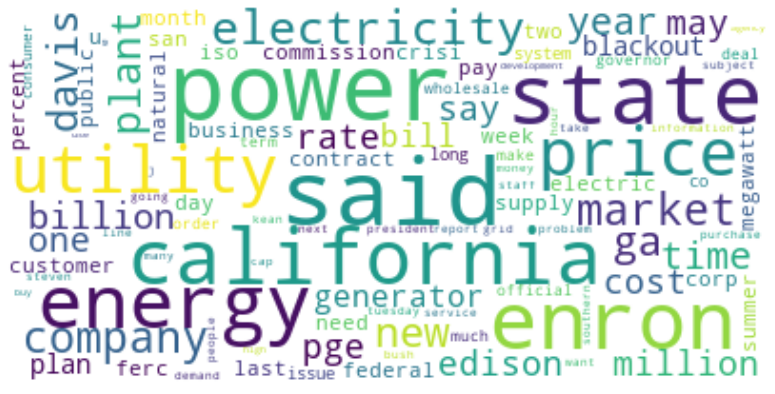

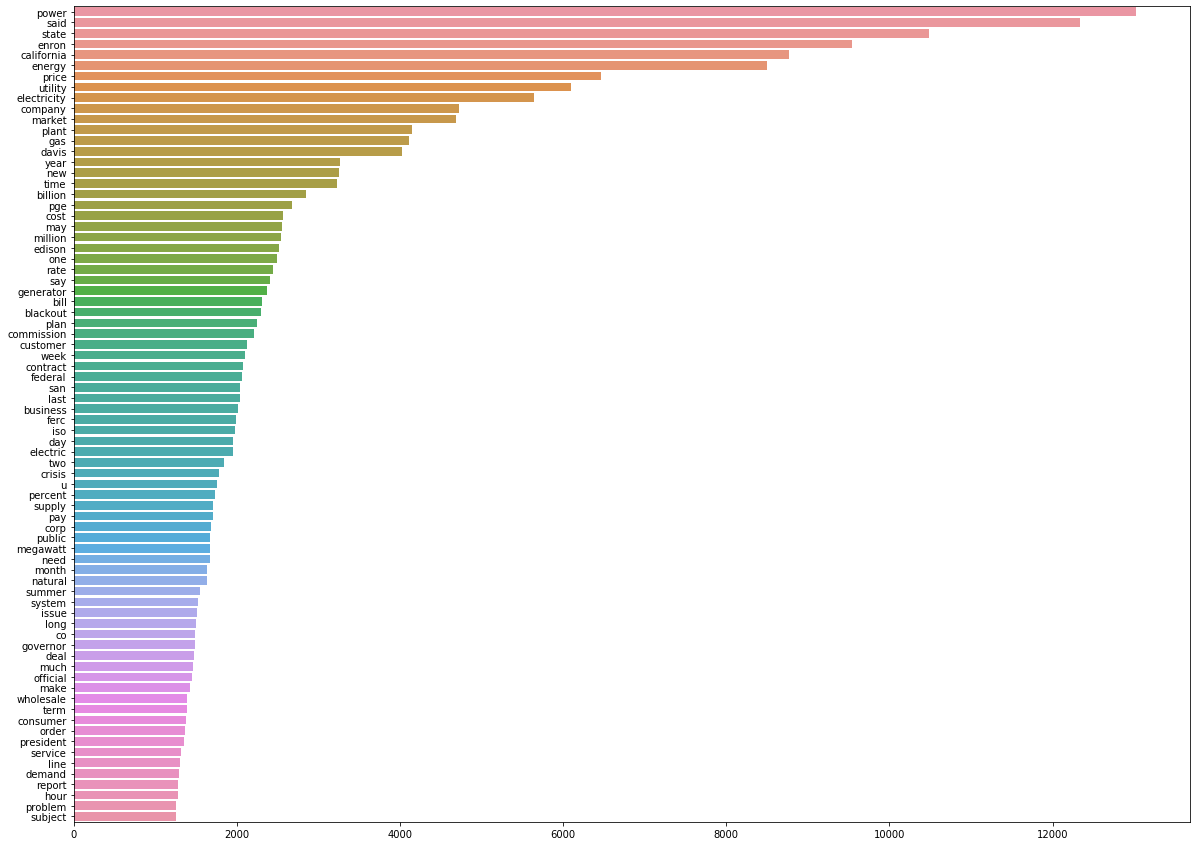

In [25]:
vocab= create_vocab(emails_refined_df['Text'], True)


In [26]:
emails_refined_df

,Folder,Subject,Content,Date,Target,Text
0,"\ExMerge - Gilbert-smith, Doug\need to read",Confidential Information and Securities Trading,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-...","Wed, 11 Jul 2001 08:29:27 -0700 (PDT)",internal company policy,exmerge gilbert smith doug need read confident...
1,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...","FW: Venezuela FX and inflation forecasts, June...",\n\n -----Original Message-----\nFrom: \tKoepk...,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)",alliances / partnerships,vkamins non privileged kaminski vince j sent i...
2,\JSKILLIN (Non-Privileged)\Deleted Items,Enron Expatriates in India,"John Brindle, David Cromley and others in the ...","Wed, 13 Jun 2001 06:05:07 -0700 (PDT)",internal company operations,jskillin non privileged deleted item enron exp...
3,\Steven_Kean_Dec2000_1\Notes Folders\All docum...,Re: PLEASE READ & RESPOND,Yes. Contact either Gia or John and get the b...,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)",internal company operations,steven kean dec note folder document please re...
4,"\Sanders, Richard B (Non-Privileged)\Sanders, ...",FW: ISO's Response to BPA Rebuttal of Sheffrin...,\nThis is something interesting to put in your...,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)",internal projects -- progress and strategy,sander richard b non privileged sander richard...
...,...,...,...,...,...,...
846,\Steven_Kean_June2001_1\Notes Folders\All docu...,Message from Clark C. Smith,include on the distribution list and send out ...,"Sun, 13 May 2001 12:37:00 -0700 (PDT)",internal company operations,steven kean june note folder document message ...
847,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE:,"Aruna,\n\nI shall be in London this week. Plea...","Mon, 25 Jun 2001 11:33:50 -0700 (PDT)",alliances / partnerships,vkamins non privileged kaminski vince j sent i...
848,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Marketing Plan & Meetings,"Sandeep,\n\nThis looks great. I would talk to ...","Tue, 26 Jun 2001 08:58:12 -0700 (PDT)",talking points,vkamins non privileged kaminski vince j sent i...
849,"\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...",RE: Test Message,"Mike,\n\nThanks for your message. The meeting ...","Wed, 27 Jun 2001 03:14:41 -0700 (PDT)",internal projects -- progress and strategy,vkamins non privileged kaminski vince j sent i...


In [41]:
text_df = emails_refined_df[['Text', 'Target']]
num_df = emails_refined_df[['Date']]

In [42]:
le = preprocessing.LabelEncoder()
text_df['Target'] = le.fit_transform(text_df.Target)
print(le.classes_)

[' company image -- current' 'alliances / partnerships'
 'california energy crisis / california politics'
 'company image -- changing / influencing' 'internal company operations'
 'internal company policy' 'internal projects -- progress and strategy'
 'legal advice' 'meeting minutes'
 'political influence / contributions / contacts'
 'regulations and regulators (includes price caps)' 'talking points'
 'trip reports']


C:\Users\PRINCY\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
num_df

,Date
0,"Wed, 11 Jul 2001 08:29:27 -0700 (PDT)"
1,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)"
2,"Wed, 13 Jun 2001 06:05:07 -0700 (PDT)"
3,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)"
4,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)"
...,...
846,"Sun, 13 May 2001 12:37:00 -0700 (PDT)"
847,"Mon, 25 Jun 2001 11:33:50 -0700 (PDT)"
848,"Tue, 26 Jun 2001 08:58:12 -0700 (PDT)"
849,"Wed, 27 Jun 2001 03:14:41 -0700 (PDT)"


## 3. Feature Engineering

### The Date column looks interesting, lets see if we can engineer the columns to get insights from the time at which the mail was sent

In [45]:
# emails_featured_df['Date'] = pd.to_datetime(emails_refined_df['Date'], infer_datetime_format=True, utc=True)
# emails_featured_df.index = pd.to_datetime(emails_featured_df.Date) # transformng indexs to datetime for ease of binning time
num_df['Date'] = pd.to_datetime(num_df['Date'], infer_datetime_format=True, utc=True)
num_df.index = pd.to_datetime(num_df.Date) # transformng indexs to datetime for ease of binning time

C:\Users\PRINCY\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
num_df.Date.dt.year

Date
2001-07-11 15:29:27+00:00    2001
2001-06-26 16:40:17+00:00    2001
2001-06-13 13:05:07+00:00    2001
2000-08-21 07:30:00+00:00    2000
2001-06-17 00:36:06+00:00    2001
                             ... 
2001-05-13 19:37:00+00:00    2001
2001-06-25 18:33:50+00:00    2001
2001-06-26 15:58:12+00:00    2001
2001-06-27 10:14:41+00:00    2001
2001-07-25 20:48:16+00:00    2001
Name: Date, Length: 851, dtype: int64

In [47]:
num_df['Year'] = num_df.Date.dt.year
num_df['Month'] = num_df.Date.dt.month
num_df['Day'] = num_df.Date.dt.day
num_df['Hour'] = num_df.Date.dt.hour


C:\Users\PRINCY\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PRINCY\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\PRINCY\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [48]:
num_df['Timeslot'] = 0

# pre working early morning hours
num_df.loc[num_df['Date'].between_time('00:00', '08:00') , 'Timeslot'] = 0 

# working morning hours
num_df.loc[num_df['Date'].between_time('08:00', '12:00') , 'Timeslot'] = 1 

# working afternoon hours
num_df.loc[num_df['Date'].between_time('12:00', '18:00') , 'Timeslot'] = 2 

# post working hours to midnight
num_df.loc[num_df['Date'].between_time('18:00', '00:00') , 'Timeslot'] = 3 



In [49]:
print (num_df.index.min())
print (num_df.index.max())


1980-01-01 00:00:00+00:00
2002-02-13 15:20:44+00:00


In [50]:
# A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.
def encode_data(data,max_val):
    sindata = np.sin(2 * np.pi * data/max_val)
    cosdata = np.cos(2 * np.pi * data/max_val)
    return sindata, cosdata

In [51]:
num_df['Month_Sin'], num_df['Month_Cos'] = encode_data(num_df['Month'], 12)
num_df['Day_Sin'], num_df['Day_Cos'] = encode_data(num_df['Day'], 365)
num_df['Hour_Sin'], num_df['Hour_Cos'] = encode_data(num_df['Hour'], 23)

In [52]:
num_df.reset_index(drop=True, inplace=True)

In [53]:
num_df.drop('Date', inplace=True, axis=1)

In [54]:
num_df

,Year,Month,Day,Hour,Timeslot,Month_Sin,Month_Cos,Day_Sin,Day_Cos,Hour_Sin,Hour_Cos
0,2001,7,11,15,2,-5.000000e-01,-0.866025,0.188227,0.982126,-0.816970,-0.576680
1,2001,6,26,16,2,1.224647e-16,-1.000000,0.432776,0.901502,-0.942261,-0.334880
2,2001,6,13,13,2,1.224647e-16,-1.000000,0.221922,0.975065,-0.398401,-0.917211
3,2000,8,21,7,0,-8.660254e-01,-0.500000,0.353676,0.935368,0.942261,-0.334880
4,2001,6,17,0,0,1.224647e-16,-1.000000,0.288482,0.957485,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
846,2001,5,13,19,3,5.000000e-01,-0.866025,0.221922,0.975065,-0.887885,0.460065
847,2001,6,25,18,3,1.224647e-16,-1.000000,0.417194,0.908818,-0.979084,0.203456
848,2001,6,26,15,2,1.224647e-16,-1.000000,0.432776,0.901502,-0.816970,-0.576680
849,2001,6,27,10,1,1.224647e-16,-1.000000,0.448229,0.893919,0.398401,-0.917211


### OBSERVATION : Oldest mail available is from year 1980 and the latest mail is from year 2002

## 4. Exploratory Data Analysis

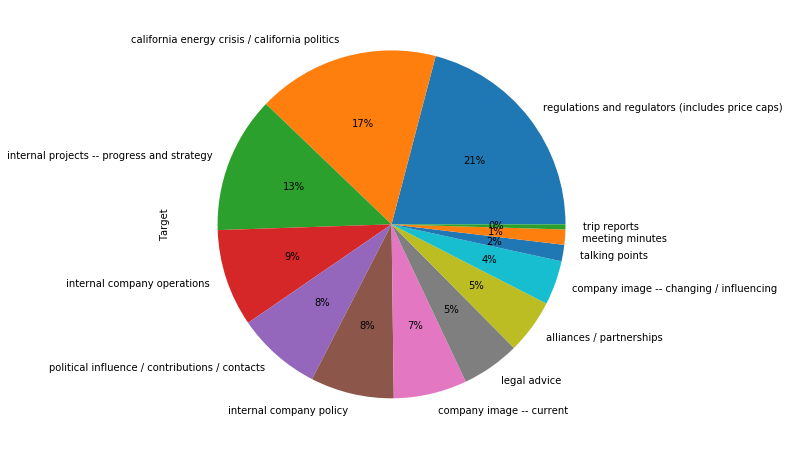

In [55]:
# Lets check the distribution of data for target 
plt.figure(figsize=(16,8))
emails_refined_df.Target.value_counts().plot(kind='pie', autopct='%1.0f%%')

### OBSERVATION : We see that the data is not equally distributed . We are to explore sampling techniques in sometime

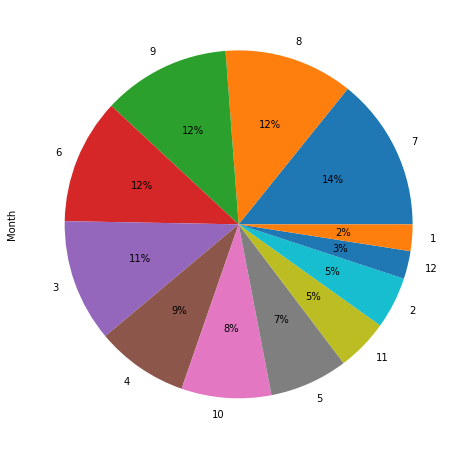

In [56]:
# Lets check the distribution of data for Months 
plt.figure(figsize=(16,8))
num_df.Month.value_counts().plot(kind='pie', autopct='%1.0f%%')

### OBSERVATION : Maximum mails have been sent in the month of july and least in January 

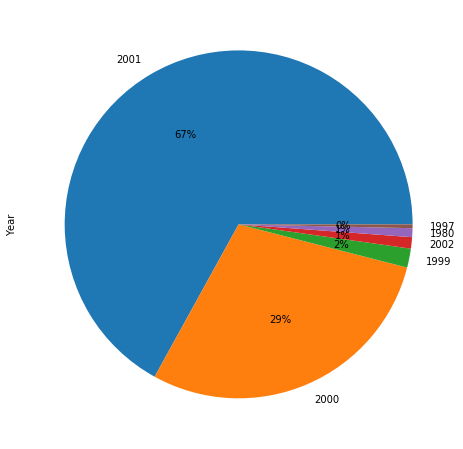

In [57]:
# Lets check the distribution of data for Year 
plt.figure(figsize=(16,8))
num_df.Year.value_counts().plot(kind='pie', autopct='%1.0f%%')

### OBSERVATION : Maximum mails in the year 2001 and least in 1997

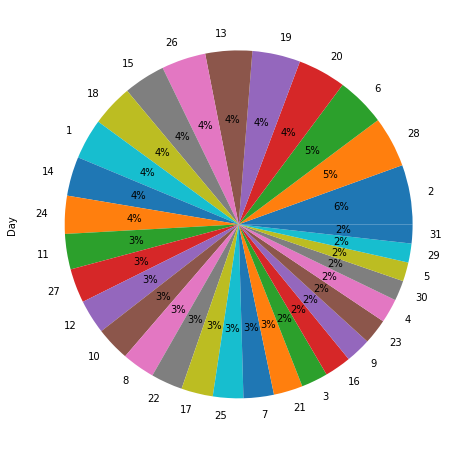

In [58]:
# Lets check the distribution of data for days of Month 
plt.figure(figsize=(16,8))
num_df.Day.value_counts().plot(kind='pie', autopct='%1.0f%%')

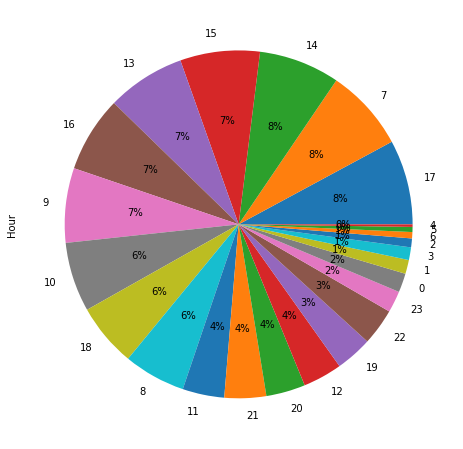

In [59]:
# Lets check the distribution of data for Year 
plt.figure(figsize=(16,8))
num_df.Hour.value_counts().plot(kind='pie', autopct='%1.0f%%')

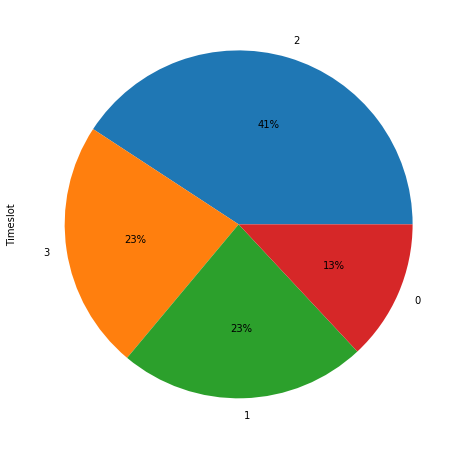

In [60]:
# Lets check the distribution of data for Timeslot 
plt.figure(figsize=(16,8))
num_df.Timeslot.value_counts().plot(kind='pie', autopct='%1.0f%%')

### OBSERVATION : We see that maximum mails were sent during afternoon working hours, followed by morning working hours

### Lets see the word cloud for each theme

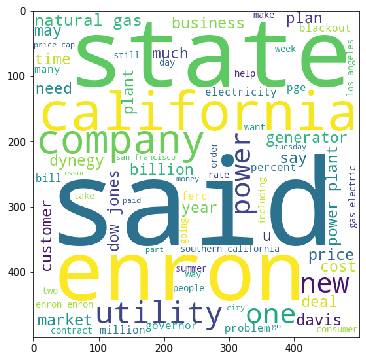

In [61]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 0]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

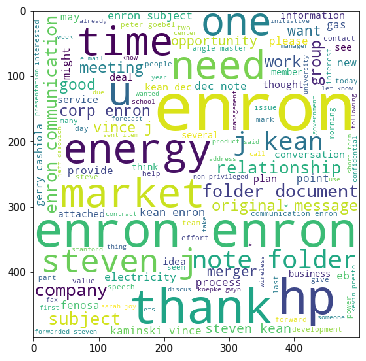

In [62]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 1]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

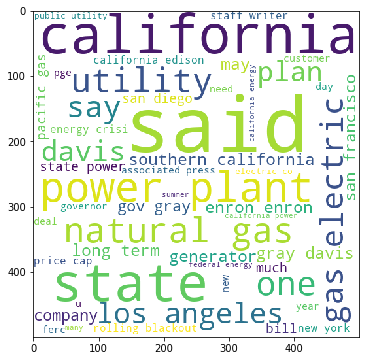

In [63]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 2]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

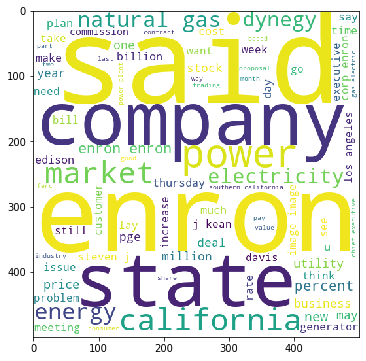

In [64]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 3]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

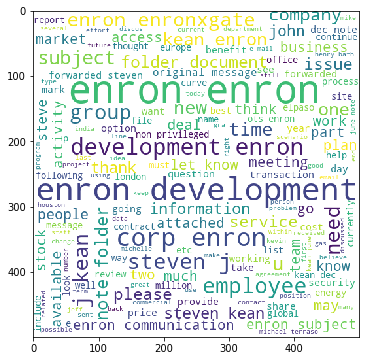

In [65]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 4]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

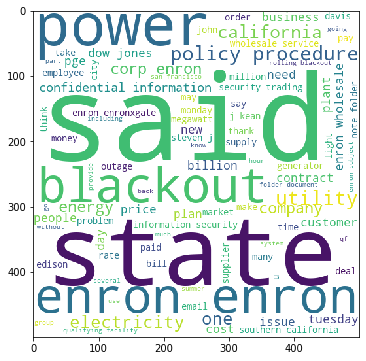

In [66]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 5]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

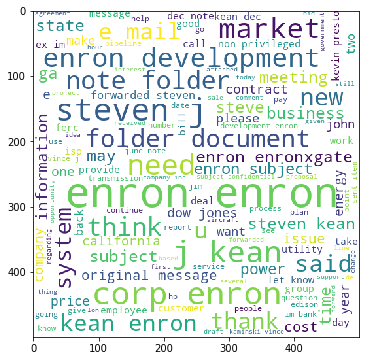

In [67]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 6]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

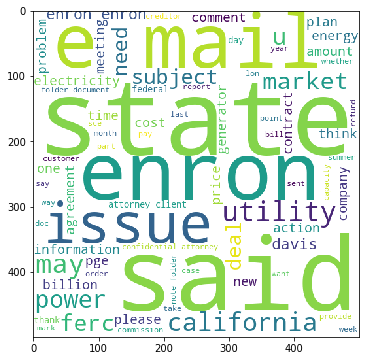

In [68]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 7]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

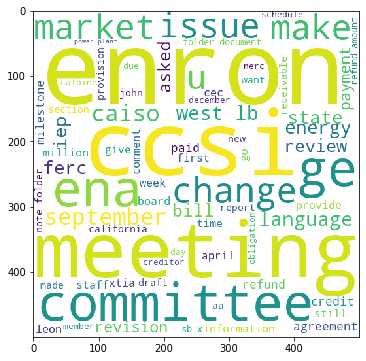

In [69]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 8]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

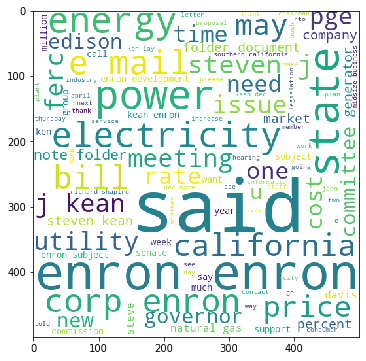

In [70]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 9]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

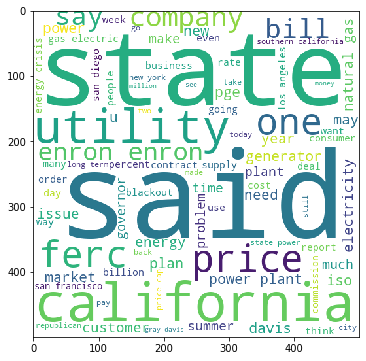

In [71]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 10]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

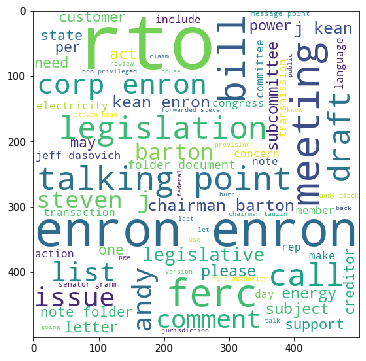

In [72]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 11]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

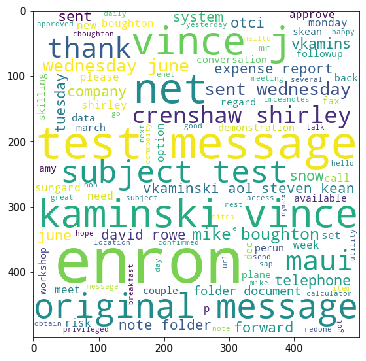

In [73]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
theme_wc = wc.generate(text_df[text_df['Target'] == 12]['Text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(theme_wc)

### We see that a lot of words are coinciding with the themes. 

## 5. Model Building first just with the Text columns

In [74]:
v = TfidfVectorizer(max_features=3000)
X = v.fit_transform(text_df['Text'])

In [75]:
transformedtext_df = pd.DataFrame(X.toarray(), columns=v.get_feature_names())


In [89]:
transformedtext_df

,aa,ab,ability,able,abraham,absolutely,abuse,accept,access,accident,...,wrongdoing,wrote,www,year,yes,yesterday,yet,york,young,zone
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.044209,0.0,...,0.0,0.0,0.000000,0.072136,0.000000,0.00000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.124744,0.078447,0.00000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0
847,0.0,0.0,0.0,0.051379,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.053496,0.000000,0.000000,0.00000,0.0,0.057201,0.0,0.0
848,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0
849,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.076183,0.000000,0.000000,0.07299,0.0,0.000000,0.0,0.0


In [76]:
y = text_df['Target']
#y.reset_index(drop=True, inplace=True)

In [503]:
#res = pd.concat([transformedtext_df, num_df], axis=1)

In [95]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


In [92]:
email_detect_theme = MultinomialNB().fit(X_train, y_train)

In [93]:
y_pred = email_detect_theme.predict(X_test)


In [94]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='micro'))
print(f1_score(y_test,y_pred,average='micro'))

0.2982456140350877
0.2982456140350877
0.2982456140350877


### Lets see how the data performs with other models 

In [90]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    svc = SVC(kernel='sigmoid', gamma=1.0)
    knc = KNeighborsClassifier()
    mnb = MultinomialNB()
    dtc = DecisionTreeClassifier(max_depth=5)
    lrc = LogisticRegression(solver='liblinear', penalty='l1')
    rfc = RandomForestClassifier(n_estimators=50, random_state=2)
    abc = AdaBoostClassifier(n_estimators=50, random_state=2)
    etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
    gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
    xgb = XGBClassifier(n_estimators=50,random_state=2)  
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='micro')
    f1 = f1_score(y_test,y_pred,average='micro')
                        
    return accuracy, precision, f1_score

In [141]:
def train_all_classifier(X_train,y_train,X_test,y_test):
     
    clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
            }
    algo_name = []
    accuracy_scores = []
    precision_scores = []
    f1_scores = []

    for name,clf in clfs.items():

        current_accuracy, current_precision,current_f1  = train_classifier(clf, X_train,y_train,X_test,y_test)

        print("For ",name)
        print("Accuracy - ",current_accuracy)
        print("Precision - ",current_precision)
        print("F1_scores - ",current_f1)

        accuracy_scores.append(current_accuracy)
        precision_scores.append(current_precision)
        f1_scores.append(current_f1)
        algo_name.append(name)
        
          
    performance_df = pd.DataFrame.from_dict({'Algorithm':algo_name,'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
      
        
    return performance_df

In [86]:
train_all_classifier(X_train,y_train,X_test,y_test)

For  SVC
Accuracy -  0.4269005847953216
Precision -  0.4269005847953216
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  KN
Accuracy -  0.40350877192982454
Precision -  0.40350877192982454
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  NB
Accuracy -  0.2982456140350877
Precision -  0.2982456140350877
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  DT
Accuracy -  0.2631578947368421
Precision -  0.2631578947368421
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  LR
Accuracy -  0.3567251461988304
Precision -  0.3567251461988304
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  RF
Accuracy -  0.3391812865497076
Precision -  0.3391812865497076
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  AdaBoost
Accuracy -  0.2222222222222222
Precision -  0.2222222222222222
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  ETC
Accuracy -  0.3216374269005848
Precision -  0.3216374269005848
F1_scores -  <function f1_score at 0x

C:\Users\PRINCY\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For  xgb
Accuracy -  0.34502923976608185
Precision -  0.34502923976608185
F1_scores -  <function f1_score at 0x0000028745C9BE58>


,Algorithm,Accuracy,Precision
0,SVC,0.426901,0.426901
1,KN,0.403509,0.403509
4,LR,0.356725,0.356725
9,xgb,0.345029,0.345029
5,RF,0.339181,0.339181
8,GBDT,0.339181,0.339181
7,ETC,0.321637,0.321637
2,NB,0.298246,0.298246
3,DT,0.263158,0.263158
6,AdaBoost,0.222222,0.222222


### Lets create a class for future use

In [82]:
class Model:
    def __init__(self,X_train,y_train,X_test,y_test, model = None):
        self.model = model,
        self.X_train = X_train,
        self.y_train = y_train,
        self.X_test = X_test,
        self.y_test = y_test,
        self.svc = SVC(kernel='sigmoid', gamma=1.0)
        self.knc = KNeighborsClassifier()
        self.mnb = MultinomialNB()
        self.dtc = DecisionTreeClassifier(max_depth=5)
        self.lrc = LogisticRegression(solver='liblinear', penalty='l1')
        self.rfc = RandomForestClassifier(n_estimators=50, random_state=2)
        self.abc = AdaBoostClassifier(n_estimators=50, random_state=2)
        self.etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
        self.gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
        self.xgb = XGBClassifier(n_estimators=50,random_state=2)
        self.clfs = {
            'SVC' : svc,
            'KN' : knc, 
            'NB': mnb, 
            'DT': dtc, 
            'LR': lrc, 
            'RF': rfc, 
            'AdaBoost': abc, 
            'ETC': etc,
            'GBDT':gbdt,
            'xgb':xgb
        }
        
    def evaluate_single_models(self):
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, self.y_pred)
        precision = precision_score(self.y_test, self.y_pred,average='micro')
        f1 = f1_score(self.y_test, self.y_pred,average='micro')

        return accuracy, precision, f1_score
    
    def evaluate_all_models(self):
        algo_name = []
        accuracy_scores = []
        precision_scores = []
        f1_scores = []

        for name,clf in self.clfs.items():

            current_accuracy, current_precision,current_f1  = train_classifier(clf, X_train,y_train,X_test,y_test)

            print("For ",name)
            print("Accuracy - ",current_accuracy)
            print("Precision - ",current_precision)
            print("F1_scores - ",current_f1)

            accuracy_scores.append(current_accuracy)
            precision_scores.append(current_precision)
            f1_scores.append(current_f1)
            algo_name.append(name)
        performance_df = pd.DataFrame.from_dict({'Algorithm':algo_name,'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
        
        return performance_df

### Lets try to make the date value as Hour, Days occur cyclic pattern and we havent considrered that before 

In [123]:
num_df = num_df[['Day', 'Hour', 'Month', 'Timeslot']].copy()

In [129]:
df = pd.concat([transformedtext_df, num_df], axis=1)

In [130]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.20, random_state = 42)


In [131]:
email_detect_theme = RandomForestClassifier().fit(X_train, y_train)

In [132]:
y_pred = email_detect_theme.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='micro'))
print(f1_score(y_test,y_pred,average='micro'))

0.3567251461988304
0.3567251461988304
0.35672514619883033


In [133]:
train_all_classifier(X_train,y_train,X_test,y_test)

For  SVC
Accuracy -  0.19298245614035087
Precision -  0.19298245614035087
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  KN
Accuracy -  0.23391812865497075
Precision -  0.23391812865497075
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  NB
Accuracy -  0.19883040935672514
Precision -  0.19883040935672514
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  DT
Accuracy -  0.2631578947368421
Precision -  0.2631578947368421
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  LR
Accuracy -  0.34502923976608185
Precision -  0.34502923976608185
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  RF
Accuracy -  0.34502923976608185
Precision -  0.34502923976608185
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  AdaBoost
Accuracy -  0.2222222222222222
Precision -  0.2222222222222222
F1_scores -  <function f1_score at 0x0000028745C9BE58>
For  ETC
Accuracy -  0.3216374269005848
Precision -  0.3216374269005848
F1_scores -  <function f1_sco

C:\Users\PRINCY\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:50:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For  xgb
Accuracy -  0.3157894736842105
Precision -  0.3157894736842105
F1_scores -  <function f1_score at 0x0000028745C9BE58>


,Algorithm,Accuracy,Precision
8,GBDT,0.368421,0.368421
4,LR,0.345029,0.345029
5,RF,0.345029,0.345029
7,ETC,0.321637,0.321637
9,xgb,0.315789,0.315789
3,DT,0.263158,0.263158
1,KN,0.233918,0.233918
6,AdaBoost,0.222222,0.222222
2,NB,0.198830,0.198830
0,SVC,0.192982,0.192982


[0.00010858 0.00050904 0.00040822 ... 0.00363856 0.00319442 0.00349792]


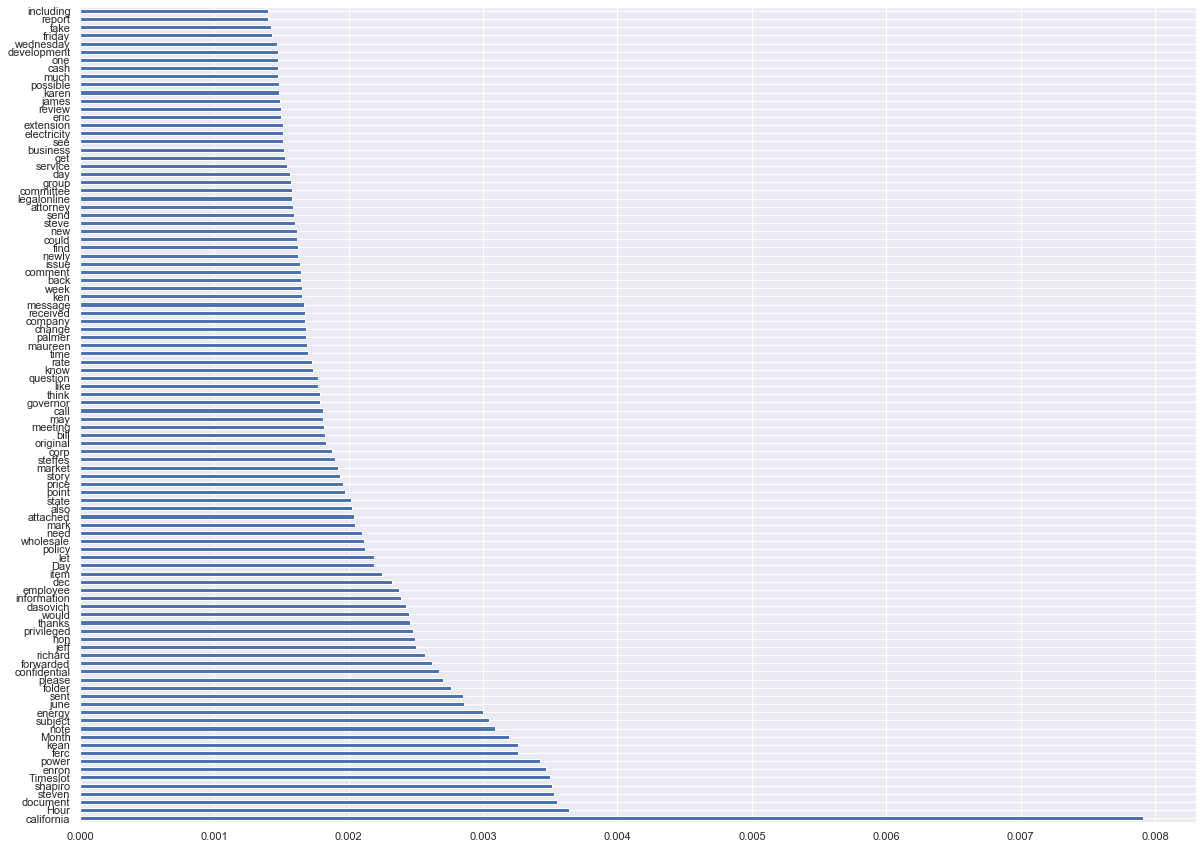

In [140]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
sns.set()
plt.figure(figsize=(20,15))
print(model.feature_importances_)
ranked_features = pd.Series(model.feature_importances_, index=X_train.columns)
ranked_features.nlargest(100).plot(kind='barh')
plt.show()